In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

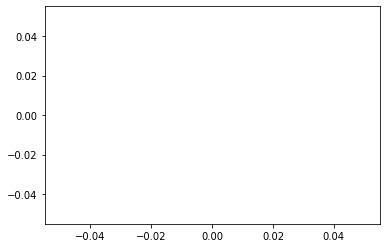

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})


In [3]:
e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#F9801D',
    'CCAT-prime':'#B02E26'
}

In [4]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'SPHEREx',
           'CCAT-prime']

In [5]:
kpar_funds = []
for experiment in e_order:
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_funds += [[kpar_fundamental, experiment]]
    
kpar_funds = list(reversed(sorted(kpar_funds)))

In [6]:
import matplotlib.patheffects as pe

In [7]:
_com = r'\textsf{\textbf{Diamonds} mark where ${\sf\Lambda} = k_\parallel^{\sf fund.}$}'

In [8]:
def hline_text(x, y, text, color="k", fontsize=12, linestyle="-", ax=None,
              left = None, right = None, path_effects = None, ha='right', lw=1,
              pad = .01):
    """ draw hline at y interrupted by text at x """
    if ax is None:
        ax = plt.gca()
    text += ' '
    text = ' ' + text
    label = ax.text(x, y, text, color='k', fontsize=fontsize,
                    va="center", ha=ha,
                   path_effects= path_effects)
    # draw text to get its bounding box
    ax.get_figure().canvas.draw()
    bbox = label.get_window_extent().transformed(ax.transAxes.inverted())
    bbox.x0 -= pad
    bbox.x1 += pad
    bbox = bbox.transformed(ax.transAxes).transformed(ax.transData.inverted())
    # add hlines next to bounding box
    if(left == None):
        left, right = ax.get_xlim()
    ax.hlines([y]*2, [left, bbox.x1], [bbox.x0, right], color=color, linestyle=linestyle, lw=lw)
    
    
    y0, y1 = bbox.y0, bbox.y1
    dy = (y1 - y0)
    yb = (y0 + y1)/2
    ax.plot([left, left], [y-dy/5, y+dy/5], color=color, lw=lw)
    ax.plot([right, right], [y-dy/5, y+dy/5], color=color, lw=lw)

CHIME 21.774558269595076
HETDEX 5.38918454251561
COMAP 1.2341717617901538
SPHEREx 0.9565531377112736
CCAT-prime 0.860834099605602


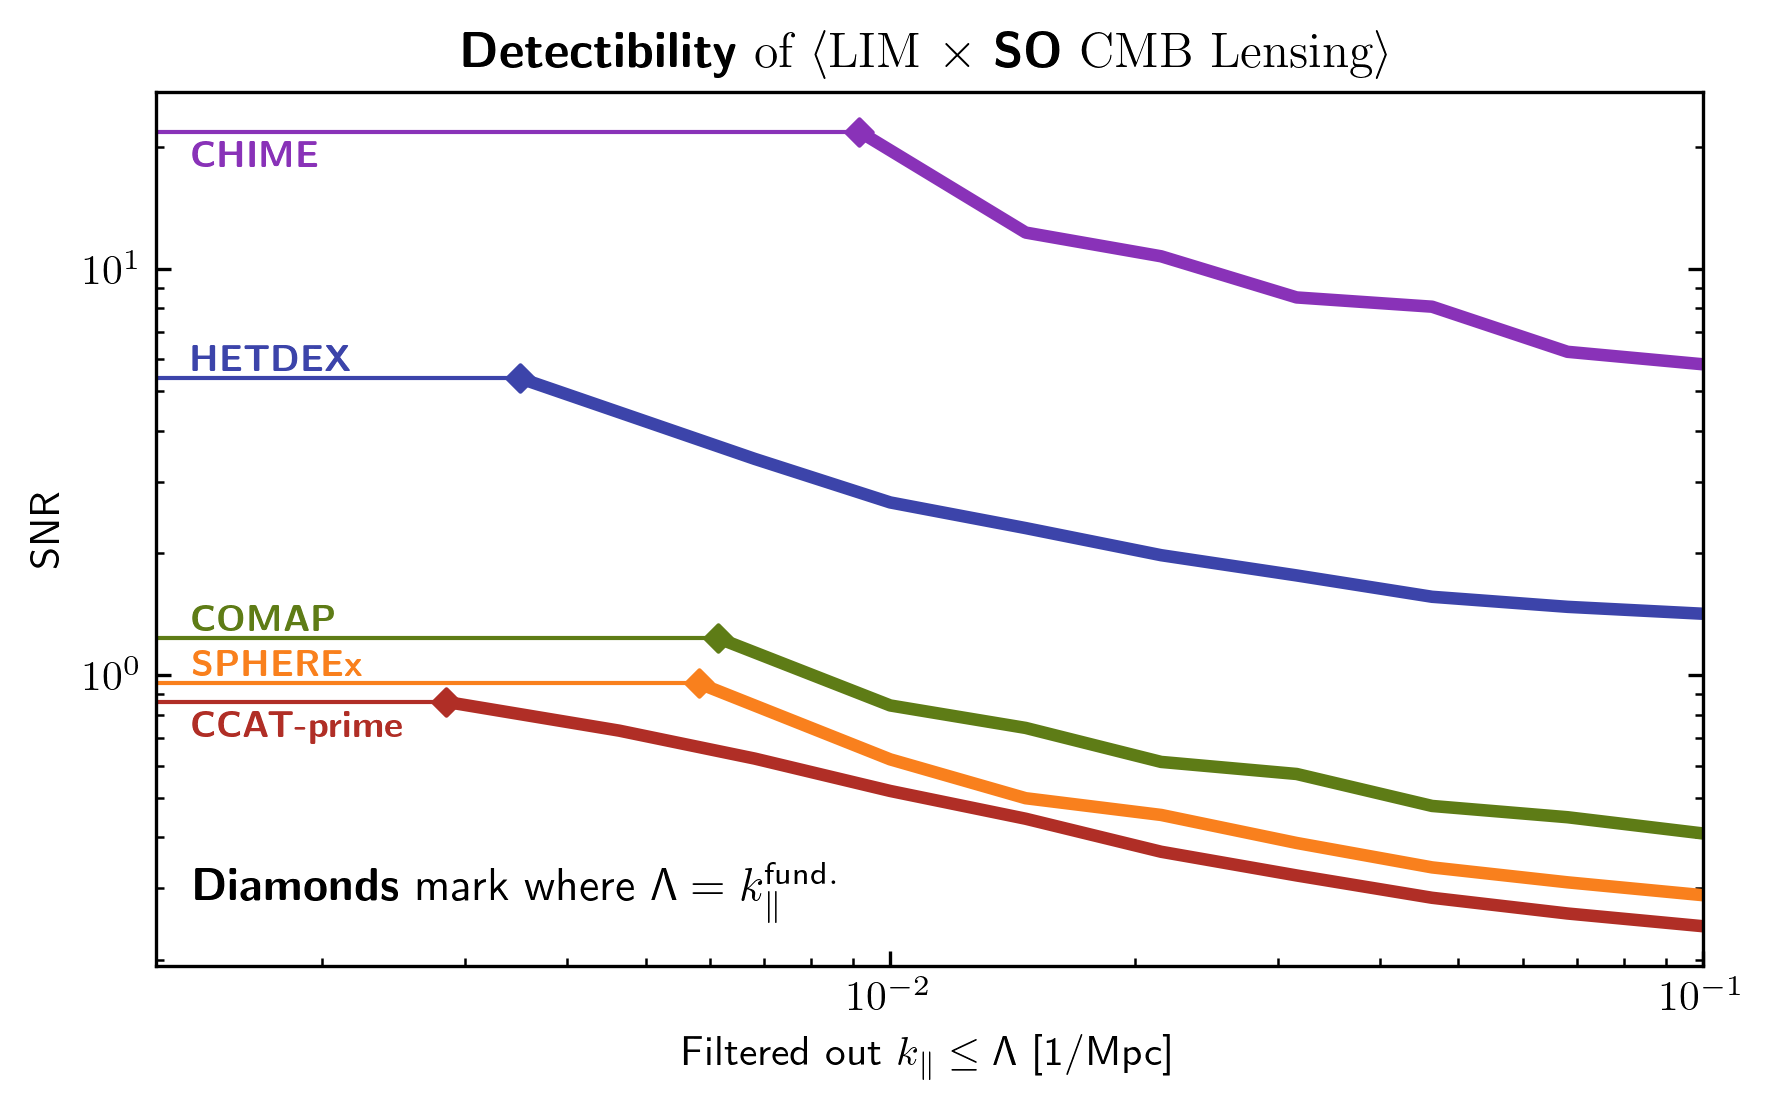

In [9]:
plt.figure(figsize = (5.8, 5.8/1.618), facecolor = 'w', dpi = 300)
xmin = 1.25e-3
sval = '0.95'

# detectibility 
# detect_thresh = 10
# plt.axhspan(0, detect_thresh, color=sval, label='No Detection')
# plt.axhspan(0, detect_thresh, alpha=1, facecolor="None", hatch='/',
#             rasterized=True,
#                                      linewidth=0,
#                                      edgecolor="k")
# plt.axhline(detect_thresh, linewidth=1,color='k')
# arrow_x = 6e-2
# arrow_length = 0.43
# plt.annotate(r'\textbf{\textsf{Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              ha='center', va='bottom', fontsize=11, color='k')


# plt.annotate(r'\textbf{\textsf{Not Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(-arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              path_effects=[pe.withStroke(linewidth=2, foreground=sval)],
#              ha='center', va='top', fontsize=11, color='none')

# plt.annotate(r'\textbf{\textsf{Not Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(-arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              ha='center', va='top', fontsize=11, color='k')


for experiment in e_order:
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)

    #load expeirment
    def get_SNR(N0_fname = 'so'):
        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)

        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
        
    _Lambdas, SNR_SO = get_SNR(N0_fname = 'so')
    _Lambdas, SNR_Planck = get_SNR(N0_fname = 'planck')
    _Lambdas, SNR_Zero = get_SNR(N0_fname = 'zero')

#     plt.fill_between(np.hstack(([0, kpar_fundamental],_Lambdas[1:])), 
#                      np.hstack(([SNR_Planck[0], SNR_Planck[0]], SNR_Planck[1:])), 
#                      np.hstack(([SNR_Zero[0], SNR_Zero[0]], SNR_Zero[1:])), 
#                     color = e_colors[experiment], alpha=0.1, lw=0)
    
    
    #plotting snr
    plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
             SNR_SO,
             c=e_colors[experiment], ls='-', lw=3,
            label=r'\textsf{%s}'%experiment)

    unfiltered_SNR_full = SNR_SO[0]
    plt.plot([0, kpar_fundamental], 
             [unfiltered_SNR_full, unfiltered_SNR_full],
             c=e_colors[experiment], lw=1,)

    plt.scatter([kpar_fundamental], [unfiltered_SNR_full],
                marker='D',
                s=20,
                c=e_colors[experiment],
                zorder=3,
               )

#     for SNR in [SNR_Planck, SNR_Zero]:
#         plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
#                  SNR,
#                  c=e_colors[experiment], ls='-', lw=1,
#                 label=r'\textsf{%s}'%experiment)
    
#         unfiltered_SNR_full = SNR[0]
#         plt.plot([0, kpar_fundamental], 
#                  [unfiltered_SNR_full, unfiltered_SNR_full],
#                  c=e_colors[experiment], lw=1, ls='-')

    
    #experiment label
    _va = 'bottom'
    texty = unfiltered_SNR_full
    if(experiment == 'CCAT-prime' or experiment == 'CHIME'):
        _va = 'top'
        texty = unfiltered_SNR_full * np.exp(-0.05)
        
#     if(texty < detect_thresh):
#         plt.text(x = xmin * np.exp(0.1), y= texty, 
#                  s=r'\textsf{\textbf{%s}}'%experiment,
#                  horizontalalignment='left',
#                  fontsize=9,
#                  color='none',
#                  path_effects=[pe.withStroke(linewidth=2, foreground=sval)],
#                  verticalalignment=_va)
    

    plt.text(x = xmin * np.exp(0.1), y= texty, 
             s=r'\textsf{\textbf{%s}}'%experiment,
             horizontalalignment='left',
             fontsize=9,
             color=e_colors[experiment],
             verticalalignment=_va)
    
    print(experiment, unfiltered_SNR_full)

    

    
# axes
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmin, 1e-1)
# plt.ylim(5e-2, 3e1)
plt.ylabel(r'\textsf{SNR}')
plt.xlabel(r'\textsf{Filtered out} $k_\parallel \leq {\sf\Lambda}$ \sf[1/Mpc]')
plt.title(r'\textbf{\textsf{Detectibility}} of $\langle$LIM $\times$ \textsf{\textbf{SO}} CMB Lensing$\rangle$')



ax = plt.gca()

# hline_text(x=xmin*np.exp(0.1), y=detect_thresh, text=r'\textsf{\textbf{Detectibility Threshold}}', lw=1,
#            color='k', fontsize=11, linestyle='-',
#            ha = 'left', pad=0.009)

ax.tick_params(axis='y', which='both', right=True)

    

plt.text(0.025,0.05, _com,
        verticalalignment='bottom',
        horizontalalignment='left',
         fontsize=11,
        transform=ax.transAxes)

plt.savefig('figures/011.007.SNR_SO.pdf', bbox_inches='tight')

CCAT-prime 64.68845289500528
SPHEREx 13.742164931448432
COMAP 75.10632220908295
HETDEX 47.11160169284874
CHIME 25.11863706591988


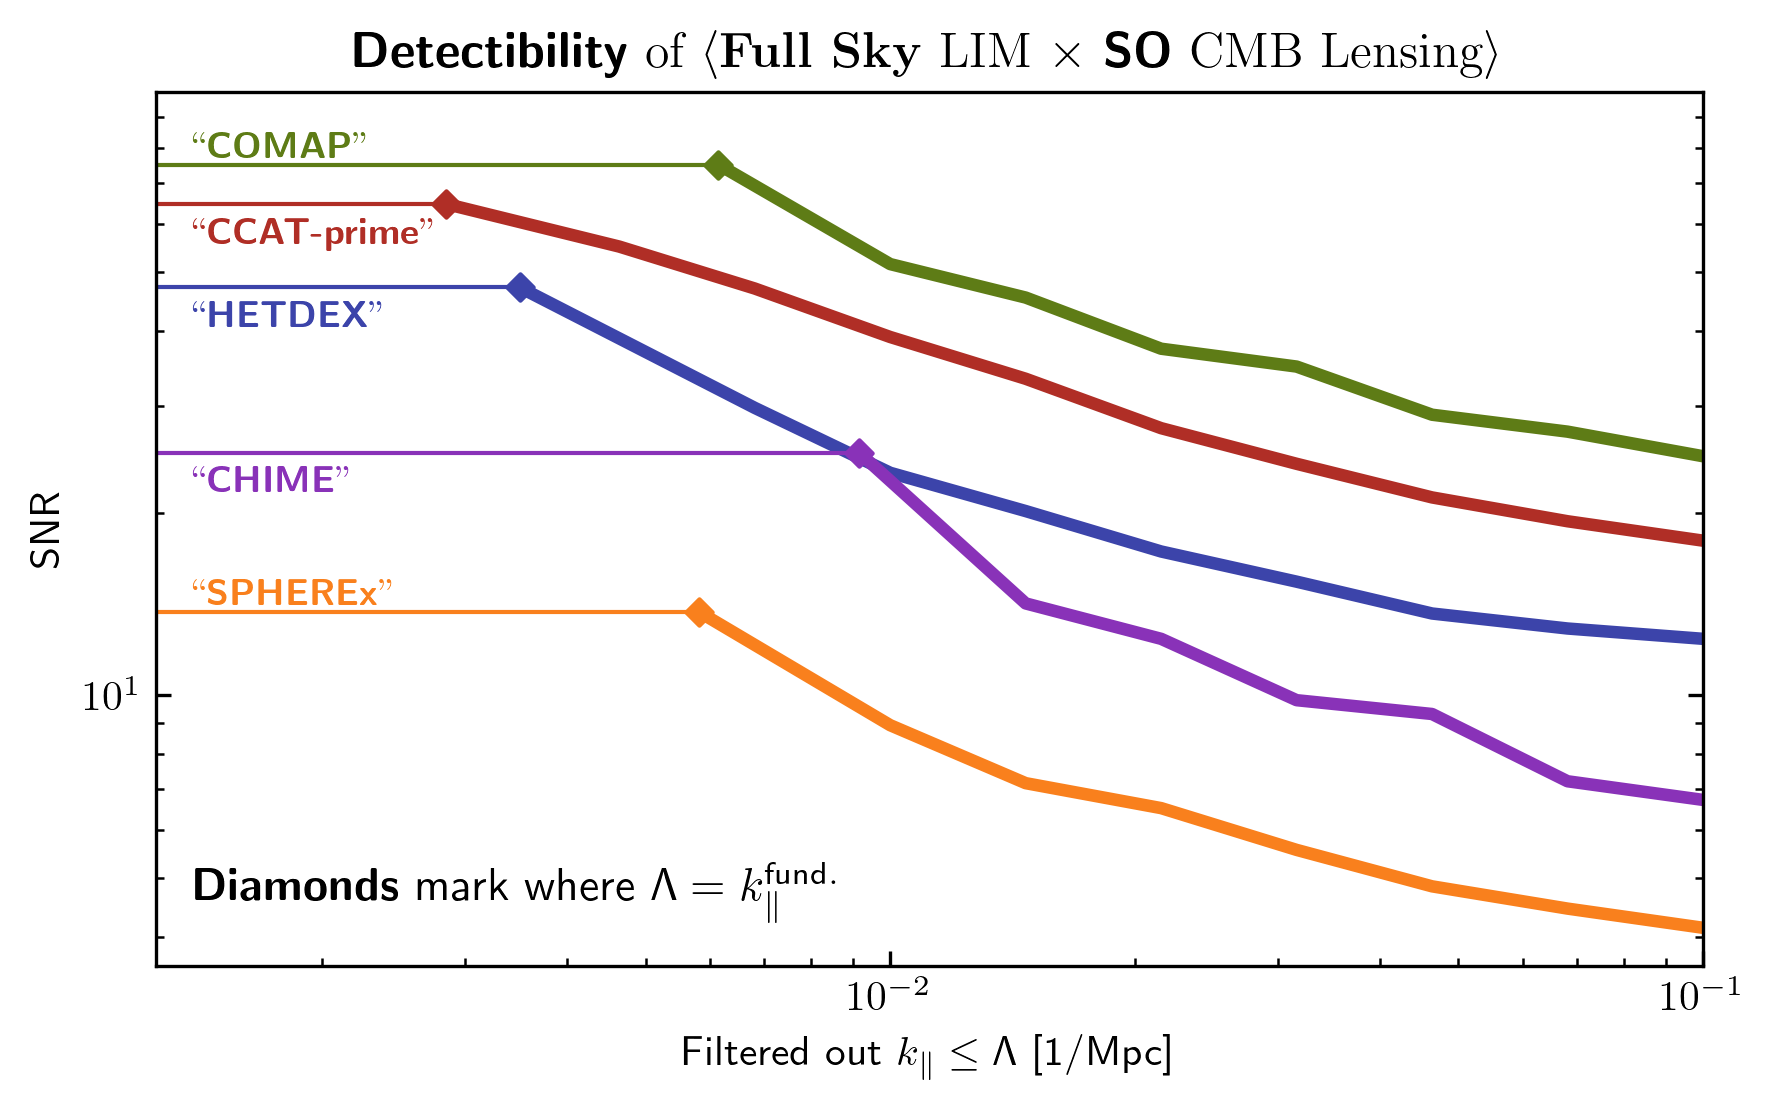

In [10]:
plt.figure(figsize = (5.8, 5.8/1.618), facecolor = 'w', dpi = 300)
# xmin = 1.25e-3
sval = '0.95'

# detectibility 
# detect_thresh = 10
# plt.axhspan(0, detect_thresh, color=sval, label='No Detection')
# plt.axhspan(0, detect_thresh, alpha=1, facecolor="None", hatch='/',
#             rasterized=True,
#                                      linewidth=0,
#                                      edgecolor="k")
# plt.axhline(detect_thresh, linewidth=1,color='k')
# arrow_x = 6e-2
# arrow_length = 0.3

# plt.annotate(r'\textbf{\textsf{Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              path_effects=[pe.withStroke(linewidth=2, foreground='1.0')],
#              ha='center', va='bottom', fontsize=11, color='none')

# plt.annotate(r'\textbf{\textsf{Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              ha='center', va='bottom', fontsize=11, color='k')


# plt.annotate(r'\textbf{\textsf{Not Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(-arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              path_effects=[pe.withStroke(linewidth=2, foreground=sval)],
#              ha='center', va='top', fontsize=11, color='none')

# plt.annotate(r'\textbf{\textsf{Not Detectible}}', xy=(arrow_x, detect_thresh), 
#              xytext=(arrow_x, detect_thresh * np.exp(-arrow_length)),
#              arrowprops=dict(arrowstyle= '<|-',
#                              facecolor='k',
#                              mutation_scale=30,
#                              lw=0,
#                              ls='-'),
#              ha='center', va='top', fontsize=11, color='k')


for experiment in e_order[::-1]:
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  4*np.pi #### FULL SKY
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)

    #load expeirment
    def get_SNR(N0_fname = 'so'):
        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        inp_fname += '_full_sky_' ##FULL SKY
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)

        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
    
    _Lambdas, SNR = get_SNR(N0_fname = 'so')

#     plt.fill_between(np.hstack(([0, kpar_fundamental],_Lambdas[1:])), 
#                      np.hstack(([SNR_Planck[0], SNR_Planck[0]], SNR_Planck[1:])), 
#                      np.hstack(([SNR_Zero[0], SNR_Zero[0]], SNR_Zero[1:])), 
#                     color = e_colors[experiment], alpha=0.1, lw=0)
    
    
    #plotting snr
    plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
             SNR,
             c=e_colors[experiment], ls='-', lw=3,
            label=r'\textsf{%s}'%experiment)


    unfiltered_SNR_full = SNR[0]
    plt.plot([0, kpar_fundamental], 
             [unfiltered_SNR_full, unfiltered_SNR_full],
             c=e_colors[experiment], lw=1,)

    plt.scatter([kpar_fundamental], [unfiltered_SNR_full],
                marker='D',
                s=20,
                c=e_colors[experiment],
                zorder=3,
               )

#     for SNR in [SNR_Planck, SNR_Zero]:
#         plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
#                  SNR,
#                  c=e_colors[experiment], ls='-', lw=1,
#                 label=r'\textsf{%s}'%experiment)
    
#         unfiltered_SNR_full = SNR[0]
#         plt.plot([0, kpar_fundamental], 
#                  [unfiltered_SNR_full, unfiltered_SNR_full],
#                  c=e_colors[experiment], lw=1, ls='-')

    
    #experiment label
    _va = 'bottom'
    texty = unfiltered_SNR_full
    if(experiment == 'CCAT-prime' or experiment == 'CHIME' or experiment=='HETDEX'):
        _va = 'top'
        texty = unfiltered_SNR_full * np.exp(-0.05)
        
#     if(texty < detect_thresh):
#         plt.text(x = xmin * np.exp(0.1), y= texty, 
#                  s=r'\textsf{\textbf{%s}}'%experiment,
#                  horizontalalignment='left',
#                  fontsize=9,
#                  color='none',
#                  path_effects=[pe.withStroke(linewidth=2, foreground=sval)],
#                  verticalalignment=_va)
    

    plt.text(x = xmin * np.exp(0.1), y= texty, 
             s=r'``\textsf{\textbf{%s}}"'%experiment,
             horizontalalignment='left',
             fontsize=9,
             color=e_colors[experiment],
             verticalalignment=_va)
    
    print(experiment, unfiltered_SNR_full)

    

    
# axes
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmin, 1e-1)
plt.ylim(None, 99)
plt.ylabel(r'\textsf{SNR}')
plt.xlabel(r'\textsf{Filtered out} $k_\parallel \leq {\sf\Lambda}$ \sf[1/Mpc]')
plt.title(r'\textbf{\textsf{Detectibility}} of $\langle$\textbf{Full Sky} LIM $\times$ \textsf{\textbf{SO}} CMB Lensing$\rangle$')


ax = plt.gca()



# hline_text(x=xmin*np.exp(0.1), y=detect_thresh, text=r'\textsf{\textbf{Detectibility Threshold}}', lw=1,
#            color='k', fontsize=11, linestyle='-',
#            ha = 'left', pad=0.009)

ax.tick_params(axis='y', which='both', right=True)

plt.text(0.025,0.05, _com,
        verticalalignment='bottom',
        horizontalalignment='left',
         fontsize=11,
        transform=ax.transAxes)


plt.savefig('figures/011.007.SNR_aspir.pdf', bbox_inches='tight')